In [134]:
import rioxarray as rx
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import os
import scipy.optimize as optimize
import geopandas as gpd
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression
os.chdir('/disk/scratch/local.4/harry/TDX/')

# Cumlative Sum of Residuals Formula

def CSR(a):
    mean = np.mean(a, axis=0)
    resid = a - mean
    return np.nancumsum(resid,axis=0)

def get_max_CSR(a):
    return xr.apply_ufunc(CSR, a).max(dim='t')

def get_min_CSR(a):
    return xr.apply_ufunc(CSR,a).min(dim='t')

def get_pixelsize(ds):
    metres = ds.rename({'lat':'y','lon':'x'}).rio.reproject('EPSG:5389')
    print((metres.x[1]-metres.x[0]).values)

In [270]:
# -------------------------------------------------------------------------------------------------
# Read in Data ------------------------------------------------------------------------------------

dem = xr.open_dataset('DEM_timeseries/DEM_timeseries_3m.nc')
asc = xr.open_dataset('intensity/nc/ascending.nc')
desc = xr.open_dataset('intensity/nc/descending.nc')
uav = '/exports/csce/datastore/geos/users/s1332488/Chapter3/intensity/UAV_change_1m_masked.tif'
uav = rx.open_rasterio(uav)
uav = uav.sel(band=1).drop('band').rio.reproject('EPSG:4326').rename({'x':'lon','y':'lat'})


get_pixelsize(dem)
get_pixelsize(asc)

2.9936771013890393


MissingCRS: CRS not found. Please set the CRS with 'rio.write_crs()'. Data variable: intensity

In [140]:
# -------------------------------------------------------------------------------------------------
# Read in Data ------------------------------------------------------------------------------------

dem = xr.open_dataset('DEM_timeseries/DEM_timeseries_3m.nc')
asc = xr.open_dataset('intensity/nc/ascending.nc')
desc = xr.open_dataset('intensity/nc/descending.nc')
uav = '/exports/csce/datastore/geos/users/s1332488/Chapter3/intensity/UAV_change_1m_masked.tif'
uav = rx.open_rasterio(uav)
uav = uav.sel(band=1).drop('band').rio.reproject('EPSG:4326').rename({'x':'lon','y':'lat'})

# Make map of features before coarsening?
# plt.figure(figsize=(12,12))
########################################


# -------------------------------------------------------------------------------------------------
# Extract features and merge datasets
# -------------------------------------------------------------------------------------------------

AOI_lon, AOI_lat = slice(-69.73,-69.705) , slice(-11.015,-11.035)

keep  = [0,1,2,3,4,5,6,6,7,8,10,11,12,13,14,15,18,19,20,21]
dem   = dem.isel(t=keep)                                             # Remove images with artefacts
coh = dem.coherence.sel(lon=AOI_lon, lat=AOI_lat)   # Crop to AOI
dem = dem.height.sel(lon=AOI_lon, lat=AOI_lat)
uav = uav.sel(lon=AOI_lon, lat=AOI_lat)
asc = asc.sel(lon=AOI_lon, lat=AOI_lat)
desc = desc.sel(lon=AOI_lon, lat=AOI_lat)

# Firstly DEM / coherence data and UAV data. Pixel size is 3m
uavD  = uav.where(uav > -100).interp_like(dem).rename('uav')         # Regrid to match TDX
h_csr = get_max_CSR(dem)                                             # Change detection feature height
trend = dem.polyfit('t',1).sel(degree=1).polyfit_coefficients        # Slope of height change
trend = (trend * (dem.t[-1] - dem.t[0]).astype(np.float64)   )       # Converted to metres
dem   = xr.merge([uavD,h_csr.rename('x0'),trend.rename('x1')])       # Merge datasets                     
# weights = coh.mean(dim='t')                                          # Coarsen to 50 m with weights?
# [[Weights via coherence did not result in any improvements...]]
#--------------------------------------------------------------------------------------------------
# weighted_x0 = (dem.x0*weights).coarsen(lat=15,lon=15,boundary='trim').sum() 
# weighted_x0 = weighted_x0 / weights.coarsen(lat=15,lon=15,boundary='trim').sum()
# weighted_x1 = (dem.x1*weights).coarsen(lat=15,lon=15,boundary='trim').sum() 
# weighted_x1 = weighted_x1 / weights.coarsen(lat=15,lon=15,boundary='trim').sum()
# uav_coarse = dem.uav.coarsen(lat=15,lon=15,boundary='trim').mean()
# dem   = xr.merge([uav_coarse.rename('uav'),weighted_x0.rename('x0'),weighted_x1.rename('x1')])
#--------------------------------------------------------------------------------------------------
# ax=plt.subplot(2,2,1)
# dem.uav.plot(vmin=-15,vmax=15)
# plt.xlim(-69.725,-69.715)
# plt.ylim(-11.025,-11.015)
# ax.set_facecolor('#c9c9c9')


# ax=plt.subplot(2,2,2)
# dem.x1.where(dem.uav>-100).plot(vmin=-15,vmax=15)
# plt.xlim(-69.725,-69.715)
# plt.ylim(-11.025,-11.015)
# ax.set_facecolor('#c9c9c9')
# dem.x1.rio.to_raster('/exports/csce/datastore/geos/users/s1332488/Chapter3/DEM/heightTrend3m.tif')
# dem.uav.rio.to_raster('/exports/csce/datastore/geos/users/s1332488/Chapter3/DEM/UAV.tif')
dem = dem.coarsen(lat=15,lon=15,boundary='trim').mean()

coh   = xr.merge([uavD,coh.rename('coh')])                          # Merge datasets

# Now intensity data. Pixel size is 2.65m

uavI = uav.where(uav > -100).interp_like(desc).rename('uav')  # Regrid to match TDX
asc  = get_max_CSR(asc).intensity.rename('x0')                # Change detection feature ascending
desc = get_max_CSR(desc).intensity.rename('x1')               # Change detection feature descending
asc  = asc.interp_like(desc)                                  # Regrid so pass directions match each other
intensity = xr.merge([uavI,asc,desc]).coarsen(lat=2,lon=2,boundary='trim').mean()   # Merge datasets
intensity.x0.rio.to_raster('/exports/csce/datastore/geos/users/s1332488/Chapter3/intensity/CSR_A.tif')
intensity.x1.rio.to_raster('/exports/csce/datastore/geos/users/s1332488/Chapter3/intensity/CSR_D.tif')
# ax=plt.subplot(2,2,3)
# intensity.x0.where(intensity.uav>-100).plot.imshow(vmin=24,vmax=-12,cmap='viridis_r')
# plt.xlim(-69.725,-69.715)
# plt.ylim(-11.025,-11.015)
# ax.set_facecolor('#c9c9c9')


# ax=plt.subplot(2,2,4)
# intensity.x1.where(intensity.uav>-100).plot.imshow(vmin=50,vmax=-25,cmap='viridis_r')
# plt.xlim(-69.725,-69.715)
# plt.ylim(-11.025,-11.015)
# ax.set_facecolor('#c9c9c9')


intensity = intensity.coarsen(lat=10,lon=10,boundary='trim').mean()      # Coarsen to 50 m
# -------------------------------------------------------------------------------------------------

# Find stats on coherence layer at 1/4 ha
coh['anom'] = coh.coh - coh.coh.mean(dim=['lat','lon'])  # Remove trend due to HoA
coh_std = coh.anom.coarsen(lat=15,lon=15,boundary='trim').std()
coh_uav = coh.uav.coarsen(lat=15,lon=15,boundary='trim').mean()
coh_x0 = get_max_CSR(coh.anom).coarsen(lat=15,lon=15,boundary='trim').mean()
coh_x1 = coh_std.polyfit('t',1).sel(degree=1).polyfit_coefficients
coh_x1 = coh_x1 * (coh_std.t[-1] - coh_std.t[0]).astype(np.float64) 
coh = xr.merge([coh_uav.rename('uav'), coh_x0.rename('x0'), coh_x1.rename('x1')])

# Double check pixel sizes and extents
print('DEM pixel size')
get_pixelsize(dem)
get_pixelsize(coh)
print('Intensity pixel size')
get_pixelsize(intensity)

DEM pixel size
44.111380785296205
44.111380785296205
Intensity pixel size
50.86642444814788


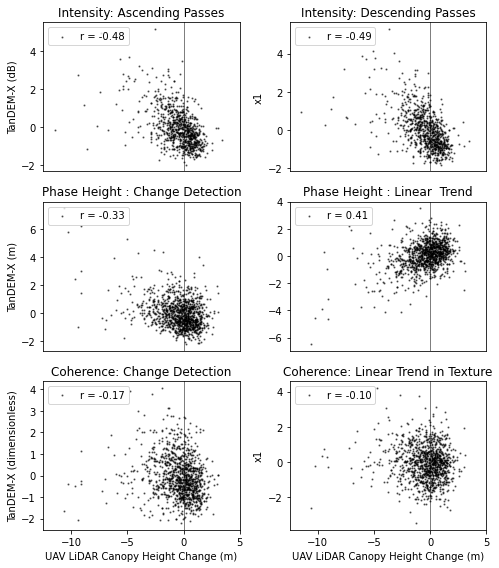

In [264]:

plt.figure(figsize=(7,8))
plt.subplot(3,2,3)
c = xr.corr(dem.uav, dem.x0)
dem.plot.scatter(x='uav',y='x0',alpha=0.5,s=5,color='black',marker='.',label="r = %.2f" % c)
plt.ylabel('TanDEM-X (m)')
plt.title('Phase Height : Change Detection')
plt.axvline(x=0,color='black',lw=1,alpha=0.5)
plt.xlim(-12.5,5)
plt.xticks([])
plt.xlabel('')
plt.legend(loc='upper left')

plt.subplot(3,2,4)
c = xr.corr(dem.uav, dem.x1)
dem.plot.scatter(x='uav',y='x1',alpha=0.5,s=5,color='black',marker='.',label="r = %.2f" % c)
plt.title('Phase Height : Linear  Trend')
plt.ylabel('')
plt.axvline(x=0,color='black',lw=1,alpha=0.5)
plt.xlim(-12.5,5)
plt.xticks([])
plt.xlabel('')
plt.legend(loc='upper left')
#---------
plt.subplot(3,2,1)
c = xr.corr(intensity.uav, intensity.x0)
intensity.plot.scatter(x='uav',y='x0',alpha=0.5,s=5,color='black',marker='.',label="r = %.2f" % c)
plt.ylabel('TanDEM-X (dB)')
plt.title('Intensity: Ascending Passes')
plt.axvline(x=0,color='black',lw=1,alpha=0.5)
plt.xlim(-12.5,5)
plt.xticks([])
plt.xlabel('')
plt.legend(loc='upper left')

plt.subplot(3,2,2)
c = xr.corr(intensity.uav, intensity.x1)
intensity.plot.scatter(x='uav',y='x1',alpha=0.5,s=5,color='black',marker='.',label="r = %.2f" % c)
plt.title('Intensity: Descending Passes')
plt.axvline(x=0,color='black',lw=1,alpha=0.5)
plt.xlim(-12.5,5)
plt.xticks([])
plt.xlabel('')
plt.legend(loc='upper left')
#---------
plt.subplot(3,2,5)
c = xr.corr(coh.uav, coh.x0)
coh.plot.scatter(x='uav',y='x0',alpha=0.5,s=5,color='black',marker='.',label="r = %.2f" % c)
plt.title('Coherence: Change Detection')
plt.ylabel('TanDEM-X (dimensionless)')
plt.axvline(x=0,color='black',lw=1,alpha=0.5)
plt.xlim(-12.5,5)
plt.xlabel('UAV LiDAR Canopy Height Change (m)')
plt.legend(loc='upper left')

plt.subplot(3,2,6)
c = xr.corr(coh.uav, coh.x1)
coh.plot.scatter(x='uav',y='x1',alpha=0.5,s=5,color='black',marker='.',label="r = %.2f" % c)
plt.title('Coherence: Linear Trend in Texture')
plt.axvline(x=0,color='black',lw=1,alpha=0.5)
plt.xlim(-12.5,5)
plt.xlabel('UAV LiDAR Canopy Height Change (m)')
plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig('/home/s1332488/Chapter3/Figures/correlations.png')

In [142]:
# Read in training area and testing area
train_aoi = gpd.read_file('/home/s1332488/Chapter3/Figures/Ph_ts/train_area.shp')
test_aoi = gpd.read_file('/home/s1332488/Chapter3/Figures/Ph_ts/test.shp')

# Define routine to optimize linear model with two features as inputs (3 parameters)

def model(ds,p0,p1,p2):
    return p0 * ds.x0 + p1 * ds.x1 + p2

def cost_fn(p,ds):
    estimate = model(ds,p[0],p[1],p[2])
    return np.sqrt( ((estimate-ds.uav)**2).sum() ).values

def fit_model(ds):
    ds = ds[['uav','x0','x1']]
    trainData = ds.rio.clip(train_aoi.geometry).where(ds.uav > -100)
    result = optimize.minimize(cost_fn,[-1,1,0],args=trainData,method='Nelder-Mead')
    print(result.message)
    print('Parameters: ',result.x)
    p = result.x
    ds['pred'] = model(ds,p[0],p[1],p[2])    
    print('r = ',xr.corr(ds.uav,ds.pred).values)
    return ds.pred

# Fit models to the three datasets
print('DEM----')
dem['pred']=fit_model(dem)
print('COH----')
coh['pred']=fit_model(coh)
print('INT----')
intensity['pred']=fit_model(intensity)

DEM----
Optimization terminated successfully.
Parameters:  [-0.05323871  0.36709032  0.00661655]
r =  0.40656626051226064
COH----
Optimization terminated successfully.
Parameters:  [-3.63566218 -3.36670594  0.13940602]
r =  0.17526121934341599
INT----
Optimization terminated successfully.
Parameters:  [ 0.05550274 -0.10641019  0.01395332]
r =  0.41711886984010077


In [209]:
def norm(da):
    return ( da - da.mean() )/ da.std()
intensity['x0'] = norm(intensity.x0)
intensity['x1'] = norm(intensity.x1)
dem['x0'] = norm(dem.x0)
dem['x1'] = norm(dem.x1)
coh['x0'] = norm(coh.x0)
coh['x1'] = norm(coh.x1)

In [243]:
def skl_fit(ds):
    ds = ds[['uav','x0','x1']]
    trainData = ds.rio.clip(train_aoi.geometry)
    x0 = trainData.x0.values.flatten()
    x1 = trainData.x1.values.flatten()
    y = trainData.uav.values.flatten()

    where = y>-100
    x0 = x0[where]
    x1 = x1[where]
    y = y[where]
    X = np.array([x0,x1]).transpose()
    reg = LinearRegression()
    reg.fit(X,y)

    print(reg.coef_,reg.intercept_)
    
    return lambda x: x.x0* reg.coef_[0] + x.x1*reg.coef_[1] + reg.intercept_

dem['pred']=skl_fit(dem)(dem)
intensity['pred']=skl_fit(intensity)(intensity)
coh['pred'] = skl_fit(coh)(coh)

[0.01504687 0.64662994] -0.6765198646596959
[-0.44441984 -0.5774987 ] -0.5971961902243192
[-0.28152165 -0.06334475] -0.6170002545134204


**
intensity
Detection Rate:  0.696078431372549
false alarm rate:  0.3486238532110092
Accuracy:  0.8114754098360656
**
phase height
Detection Rate:  0.5772357723577236
false alarm rate:  0.4740740740740741
Accuracy:  0.7583333333333333
**
coherence
Detection Rate:  0.17886178861788618
false alarm rate:  0.5510204081632653
Accuracy:  0.7333333333333333


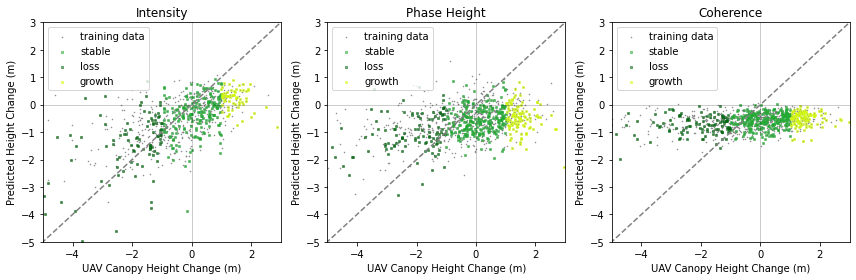

*****
Total degradation rate:  0.28623853211009176


In [269]:
def plot_results(ds):
    testData = ds.rio.clip(test_aoi.geometry).where(ds.uav > -100)
    trainData = ds
    plt.axvline(x=0,alpha=0.2,lw=1,color='black')
    plt.axhline(y=0,alpha=0.2,lw=1,color='black')
#     plt.plot([1,1],[1,3],alpha=0.2,lw=1,color='black')
#     plt.plot([1,3],[1,1],alpha=0.2,lw=1,color='black')
#     plt.plot([-1,-1],[-1,-7],alpha=0.2,lw=1,color='black')
#     plt.plot([-1,-7],[-1,-1],alpha=0.2,lw=1,color='black')
    plt.plot([-7,3],[-7,3],color='grey',ls='--')
    noChange = testData.where((testData.uav >= -1)*(testData.uav <= 1))
    fall = testData.where(testData.uav<-1)
    grow = testData.where(testData.uav>1)
    trainData.plot.scatter(x='uav',y='pred',s=1,color='grey',marker='.',label='training data')
    noChange.plot.scatter(x='uav',y='pred',s=2,color='#22ab34',marker='s',alpha=0.5,label='stable')
    fall.plot.scatter(x='uav',y='pred',s=2,color='#00660e',marker='s',alpha=0.5,label='loss')
    grow.plot.scatter(x='uav',y='pred',s=2,color='#d4fc0d',marker='s',alpha=0.5,label='growth')
    plt.xlabel('UAV Canopy Height Change (m)')
    plt.ylabel('Predicted Height Change (m)')
    
    positives = ((testData.uav < -1)*(testData.uav > -100)).sum()
    flagged = (testData.pred < -1).sum()
    true_pos = ((testData.uav < -1) * (testData.pred < -1)).sum()
    detection_rate = true_pos/positives
    false_alarms = 1 - (true_pos/flagged)
    true_neg = ((testData.uav >= -1)* (testData.pred >= -1)).sum()
    accuracy = (true_pos + true_neg)/(testData.uav > -100).sum()
    print('Detection Rate: ',detection_rate.values)
    print('false alarm rate: ',false_alarms.values)
    print('Accuracy: ',accuracy.values)
    
    
    plt.xlim(-5,3)
    plt.ylim(-5,3)
    plt.legend(loc='upper left')
    
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
print('**')
print('intensity')
plot_results(intensity)
plt.title('Intensity')
plt.subplot(1,3,2)
print('**')
print('phase height')
plot_results(dem)
plt.title('Phase Height')
plt.subplot(1,3,3)
print('**')
print('coherence')
plot_results(coh)
plt.title('Coherence')
plt.tight_layout()
plt.savefig('/home/s1332488/Chapter3/Figures/change_detection.png',dpi=400)
plt.show()
print('*****')
print('Total degradation rate: ',  (((dem.uav < -1).sum()) / ((dem.uav>-100).sum()) ).values )

In [238]:
plots

,N_trees,N_logged,AGB_pre,AGB_loss,AGB_loss_p,x_coord,y_coord,subplot,geometry
0,180.0,2.0,58.844169,6.394338,10.866562,23.0,21.0,PC1a,"POLYGON ((-69.72334 -11.03299, -69.72334 -11.0..."
1,153.0,2.0,97.031714,42.271777,43.564908,24.0,75.0,PC1b,"POLYGON ((-69.72334 -11.03253, -69.72334 -11.0..."
2,202.0,2.0,51.756284,7.520668,14.530927,75.0,24.0,PC1c,"POLYGON ((-69.72283 -11.03255, -69.72240 -11.0..."
3,176.0,1.0,78.069072,24.672602,31.603554,75.0,75.0,PC1d,"POLYGON ((-69.72286 -11.03207, -69.72239 -11.0..."
4,233.0,2.0,83.752301,4.913761,5.867016,30.0,26.0,PC2a,"POLYGON ((-69.72310 -11.02764, -69.72361 -11.0..."
5,157.0,2.0,81.352875,6.566388,8.071489,27.0,59.0,PC2b,"POLYGON ((-69.72338 -11.02694, -69.72315 -11.0..."
6,186.0,0.0,96.174405,11.819693,12.289853,108.0,26.0,PC2c,"POLYGON ((-69.72387 -11.02653, -69.72338 -11.0..."
7,90.0,0.0,43.760366,0.373649,0.853852,112.0,61.0,PC2d,"POLYGON ((-69.72338 -11.02694, -69.72387 -11.0..."
8,227.0,1.0,130.925093,5.318859,4.062520,37.0,24.0,PC3a,"POLYGON ((-69.72240 -11.02397, -69.72216 -11.0..."
9,190.0,3.0,96.363883,12.450402,12.920195,30.0,70.0,PC3b,"POLYGON ((-69.72216 -11.02354, -69.72194 -11.0..."


PC1
PC2
PC3
PC4


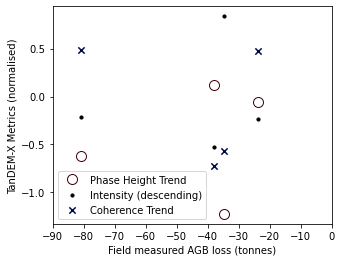

In [212]:


loc1 = '/exports/csce/datastore/geos/groups/MitchardGroupData/FODEX/core_plot_shapefiles/core_plots.shp'
loc2 = '/exports/csce/datastore/geos/groups/MitchardGroupData/FODEX/Forest_inventory/PeruPlots.csv'
plot_shp = gpd.read_file(loc1)
plot_shp = plot_shp[['P' in p for p in plot_shp.layer]]
plot_data = pd.read_csv(loc2)
plots = pd.merge(plot_data,plot_shp,left_on='Plot',right_on='layer')[['Plot','AGB_loss','AGB_loss_pct','geometry']]
plots['geometry'] = gpd.GeoSeries(plots.geometry).to_crs('EPSG:5387').buffer(10).to_crs('EPSG:4326')

for plot in ['PC1','PC2','PC3','PC4']:
    print(plot)
    plots.at[plots.Plot==plot,'I1'] = intensity.x0.rio.clip(plots[plots.Plot==plot].geometry).mean().values
    plots.at[plots.Plot==plot,'I2'] = intensity.x1.rio.clip(plots[plots.Plot==plot].geometry).mean().values
    plots.at[plots.Plot==plot,'H1'] = dem.x0.rio.clip(plots[plots.Plot==plot].geometry).mean().values
    plots.at[plots.Plot==plot,'H2'] = dem.x1.rio.clip(plots[plots.Plot==plot].geometry).mean().values
    plots.at[plots.Plot==plot,'coh'] = coh.x1.rio.clip(plots[plots.Plot==plot].geometry).mean().values
plots['AGB_loss'] = -plots.AGB_loss

plt.figure(figsize=(5,4))#
ax = plt.axes()
# plots.plot.scatter(x='AGB_loss',y='I1',ax=ax,color='black',marker='x')
plots.plot.scatter(x='AGB_loss',y='I2',ax=ax,color='black',marker='.',s=40
                  ,label='Intensity (descending)')
# plots.plot.scatter(x='AGB_loss',y='H1',ax=ax,color='orange',marker='x')
ax.plot(plots['AGB_loss'],plots['H2'],color='#42000a',marker='o',
        markersize=10,fillstyle='none',lw=0,label='Phase Height Trend')
plots.plot.scatter(x='AGB_loss',y='coh',ax=ax,color='#000a42',marker='x',s=40
                  ,label='Coherence Trend')
plt.ylabel('TanDEM-X Metrics (normalised)')
plt.xlabel('Field measured AGB loss (tonnes)')
plt.xlim(-90,0)
plt.legend(loc='lower left')
plt.savefig('/home/s1332488/Chapter3/Figures/TDX_vs_plots.png')
plt.show()